# Transfer Learning Part 2: Fine-tuning 

## IMporting helper functions

Rewriting certain functions to monitor and evaluate our model can be tedious, so we can make our own script for some mundane activities

### Downloading hellper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# IMporting from helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get Some data

In [5]:
# Get 10% of our data and unzip it

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-12 12:12:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:81f::201b, 2404:6800:4009:820::201b, 2404:6800:4009:824::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:81f::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

10_food_classes_10_ 100%[===================>] 160.74M  17.3MB/s    in 11s     

2024-02-12 12:12:40 (14.3 MB/s) - '10_food_classes_10_percent.zip' saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [7]:
# Create training and test directory paths
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# Check out class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an axample of batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [5.79596806e+00 1.42345536e+00 0.00000000e+00]
   [1.05714674e+01 6.88783884e-01 0.00000000e+00]
   [1.63571777e+01 2.00003481e+00 0.00000000e+00]]

  [[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [8.67353153e+00 3.41816425e-01 0.00000000e+00]
   [1.57806635e+01 2.85727262e-01 5.10297250e-03]
   [2.18316650e+01 2.47452211e+00 9.18317065e-02]]

  [[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [1.85664005e+01 2.78571439e+00 6.17364168e-01]
   [2.68724785e+01 3.85715604e+00 1.53060496e+00]
   [3.22092133e+01 4.78571415e+00 1.56628418e+00]]

  ...

  [[1.78570557e+00 3.21429443e+00 0.00000000e+00]
   [1

2024-02-12 12:22:43.282836: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Model 0: Building a transfer learning model using Keras Functionsal API

The sequential API is straight-forwar, it runs our layers in sequential order.

But the functiosn API gives us more flexibility with our models

In [14]:
# 1. Create base model, with tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")

# 4. If using a model like ResNEt50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average poo the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)


# 8. Combing the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# 10. Fit the model and save its hsitory
history_0 = model_0.fit(train_data,
                        epochs= 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= len(test_data),
                        callbacks= [create_tensorboard_callback(
                            dir_name= "tensorflow_hub", experiment_name= 'model_0')]) 

24274472/24274472 [==============================] - 3s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/model_0/20240212-124922
Epoch 1/5
24/24 [==============================] - 24s 947ms/step - loss: 1.8985 - accuracy: 0.4160 - val_loss: 1.3319 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 22s 936ms/step - loss: 1.1480 - accuracy: 0.7693 - val_loss: 0.9031 - val_accuracy: 0.8032
Epoch 3/5
24/24 [==============================] - 22s 936ms/step - loss: 0.8376 - accuracy: 0.8240 - val_loss: 0.7191 - val_accuracy: 0.8364
Epoch 4/5
24/24 [==============================] - 21s 912ms/step - loss: 0.6728 - accuracy: 0.8560 - val_loss: 0.6237 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 22s 926ms/step - loss: 0.5856 - accuracy: 0.8733 - val_loss: 0.5672 - val_accuracy: 0.8568


In [15]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 17s 216ms/step - loss: 0.5672 - accuracy: 0.8568


[0.5672491788864136, 0.8568000197410583]

In [16]:
# Check the layers in our base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [17]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [18]:
# how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


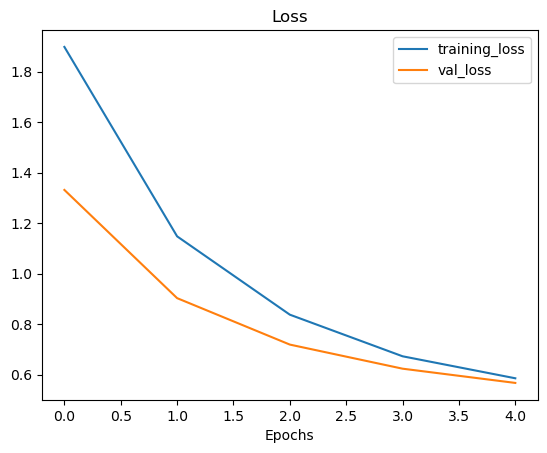

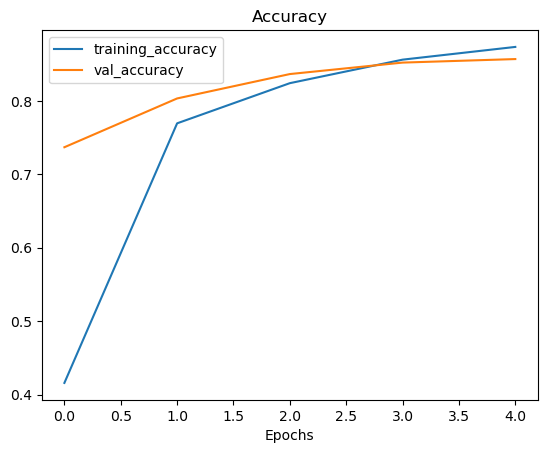

In [19]:
plot_loss_curves(history_0)

## Getting feature vector form trained model

Let's demonstrate GlobalAveragePooling2D layer

We have a tensor after our modle goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.

In [23]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor} \n")

# Passing the random tensor trhough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

#Check the shape of the different tensord
print(f"Shape of input tensord: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensord: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]] 

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840445 -0.28855976]] 

Shape of input tensord: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensord: (1, 3)


In [25]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> **Practice**: Try to do the same withthe above two cells but this time use `GlobalMaxPool2D` ... and see what happens

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunmch of experiments to find out:

1. `model_1` use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation


> **Note**: throughout all the experiments the same test dataset will be used to evaluate our model... thsi ensures consistency across evaluation metrics

## Getting and preprocessing our data for model_1

In [26]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-02-12 13:32:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:82c::201b, 2404:6800:4009:82d::201b, 2404:6800:4009:82e::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:82c::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: '10_food_classes_1_percent.zip'

10_food_classes_1_p 100%[===================>] 127.42M  16.4MB/s    in 9.2s    

2024-02-12 13:32:42 (13.9 MB/s) - '10_food_classes_1_percent.zip' saved [133612354/133612354]



In [27]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [28]:
# Creating training and test dir
TRAIN_DIR_1 = "10_food_classes_1_percent/train/"
TEST_DIR_1 = "10_food_classes_1_percent/test/"

In [29]:
# Setup data loaders

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
